Testing 100k Hindi dataset
Load the CSV file into the folder where the notebook is located

In [6]:
# Clone the NanoGPT
!git clone https://github.com/karpathy/nanoGPT.git

fatal: destination path 'nanoGPT' already exists and is not an empty directory.


In [7]:
!pip install wandb


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import nanoGPT.model as GPT
import wandb
import os

In [9]:
# from kaggle_secrets import UserSecretsClient
# # Load API keys https://www.kaggle.com/discussions/product-feedback/114053
# secret_label = "WANDB_API_KEY"
my_secret = "c2e3619f245387906ce0bd58733dc79534a116bc"

In [10]:
class GPTConfig:
    block_size: int = 256
    vocab_size: int = 65400  # Increased to handle the full token range (65398 + some padding)
    n_layer: int = 12
    n_head: int = 8
    n_embd: int = 192
    dropout: float = 0.2
    bias: bool = True

config = GPTConfig

In [11]:
wandb_config = {k:v for k,v in vars(config).items() if not callable(getattr(config, k)) and not k.startswith("__")} # Creating Wandb hyperparameters config for tracking experiements
wandb_config

{'block_size': 256,
 'vocab_size': 65400,
 'n_layer': 12,
 'n_head': 8,
 'n_embd': 192,
 'dropout': 0.2,
 'bias': True}

In [12]:
wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nisargbhavsar. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/malhar.inamdar/.netrc


True

                                        Read the Hindi CSV file , create train & validation splits

In [13]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def get_script_directory():
    """
    Get the directory of the current script, working across different environments.

    Returns:
    --------
    str: Directory path of the current script or current working directory
    """
    try:
        return os.path.dirname(os.path.abspath(__file__))
    except NameError:
        return os.getcwd()

def prepare_hindi_text_dataset(
    filename,
    text_column_index=0,  # Default to first column
    train_size=0.8,
    random_state=42,
    search_paths=None,
    encoding='utf-8'
):
    """
    Read a CSV file without headers and create train/validation splits.

    Parameters:
    -----------
    filename : str
        Name of the CSV file
    text_column_index : int, optional (default=0)
        Index of the column containing text data
    train_size : float, optional (default=0.8)
        Proportion of data to use for training (remaining for validation)
    random_state : int, optional (default=42)
        Seed for random split reproducibility
    search_paths : list, optional
        Additional paths to search for the file
    encoding : str, optional (default='utf-8')
        Encoding of the CSV file

    Returns:
    --------
    tuple: (train_texts, val_texts)
        Lists of training and validation texts
    """
    # Add default search paths
    if search_paths is None:
        search_paths = [
            get_script_directory(),
            os.getcwd(),
            os.path.expanduser('~')
        ]

    # Try to find the file in the search paths
    csv_path = None
    for path in search_paths:
        potential_path = os.path.join(path, filename)
        if os.path.exists(potential_path):
            csv_path = potential_path
            break

    # Raise error if file not found
    if csv_path is None:
        raise FileNotFoundError(f"Could not find {filename} in the specified search paths.")

    try:
        # Read CSV file without headers
        df = pd.read_csv(
            csv_path,
            encoding=encoding,
            header=None  # No header row
        )

        # Validate text column index
        if text_column_index >= len(df.columns):
            raise ValueError(f"Column index {text_column_index} is out of range.")

        # Select the specified column
        texts = df[text_column_index].tolist()

        # Remove any rows with NaN or empty values
        texts = [str(text).strip() for text in texts if pd.notna(text) and str(text).strip()]

        # Split into train and validation sets
        train_texts, val_texts = train_test_split(
            texts,
            train_size=train_size,
            random_state=random_state
        )

        print(f"Dataset processed from: {csv_path}")
        print(f"Total texts: {len(texts)}")
        print(f"Training texts: {len(train_texts)}")
        print(f"Validation texts: {len(val_texts)}")

        return train_texts, val_texts

    except Exception as e:
        print(f"Error processing dataset: {e}")
        return None, None

def preprocess_text(text):
    """
    Preprocessing function for Hindi text.

    Parameters:
    -----------
    text : str
        Input text to preprocess

    Returns:
    --------
    str: Preprocessed text
    """
    # Comprehensive text preprocessing for Hindi
    if not isinstance(text, str):
        return ""

    # Remove leading/trailing whitespaces
    text = text.strip()

    # Optional: Add more preprocessing steps for Hindi text
    # - Convert to lowercase
    # - Remove extra whitespaces
    # - Remove special characters if needed

    return text

def save_processed_datasets(train_texts, val_texts, original_filename):
    """
    Save processed train and validation texts to CSV files.

    Parameters:
    -----------
    train_texts : list
        List of training texts
    val_texts : list
        List of validation texts
    original_filename : str
        Original filename to base output filenames on
    """
    # Get the directory to save files
    save_dir = get_script_directory()

    # Create output filenames based on original filename
    base_name = os.path.splitext(original_filename)[0]
    train_output = os.path.join(save_dir, f"{base_name}_train.csv")
    val_output = os.path.join(save_dir, f"{base_name}_val.csv")

    # Save train texts
    pd.DataFrame(train_texts, columns=['text']).to_csv(train_output, index=False, encoding='utf-8')
    print(f"Training texts saved to: {train_output}")

    # Save validation texts
    pd.DataFrame(val_texts, columns=['text']).to_csv(val_output, index=False, encoding='utf-8')
    print(f"Validation texts saved to: {val_output}")

def main():
    # Specify filename
    filename = '/Users/malhar.inamdar/Desktop/task/tinystories_hindi_first_100000.csv'  # Replace with your actual filename

    # You can optionally specify additional search paths
    search_paths = [
        os.getcwd(),  # Current working directory
        os.path.expanduser('~/Documents'),  # Example additional path
    ]

    # Prepare dataset
    train_texts, val_texts = prepare_hindi_text_dataset(
        filename,
        text_column_index=0,  # Use first column, adjust if needed
        train_size=0.8,  # 80% train, 20% validation
        search_paths=search_paths,  # Optional: additional search paths
        encoding='utf-8'  # Specify encoding for Hindi text
    )

    # Optional: Apply preprocessing
    if train_texts:
        train_texts = [preprocess_text(text) for text in train_texts]
        val_texts = [preprocess_text(text) for text in val_texts]

        # Optional: Save processed datasets
        save_processed_datasets(train_texts, val_texts, filename)

if __name__ == "__main__":
    main()

Dataset processed from: /Users/malhar.inamdar/Desktop/task/tinystories_hindi_first_100000.csv
Total texts: 99984
Training texts: 79987
Validation texts: 19997
Training texts saved to: /Users/malhar.inamdar/Desktop/task/tinystories_hindi_first_100000_train.csv
Validation texts saved to: /Users/malhar.inamdar/Desktop/task/tinystories_hindi_first_100000_val.csv


                                                      Toeknize the dataset, Create the binary files for model run

In [15]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from IndicTransToolkit import IndicProcessor
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

def tokenize_dataset(
    csv_file_path,
    tokenizer_model="ai4bharat/indictrans2-en-indic-dist-200M",
    output_bin_file=None,
    num_proc=8
):
    """
    Tokenize a CSV dataset using IndicTrans Toolkit and create a binary file for training.

    Parameters:
    -----------
    csv_file_path : str
        Path to the CSV file containing texts
    tokenizer_model : str, optional
        Hugging Face tokenizer model to use (default: IndicTrans model)
    output_bin_file : str, optional
        Output binary filename (defaults to CSV filename with .bin extension)
    num_proc : int, optional
        Number of processors to use for tokenization

    Returns:
    --------
    np.memmap: Tokenized dataset as a memory-mapped array
    """
    # Validate file exists
    if not os.path.exists(csv_file_path):
        raise FileNotFoundError(f"CSV file not found: {csv_file_path}")

    # Initialize IndicTrans components
    ip = IndicProcessor(inference=True)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_model, trust_remote_code=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(tokenizer_model, trust_remote_code=True)

    # Read CSV file
    df = pd.read_csv(csv_file_path)

    # Ensure 'text' column exists
    if 'text' not in df.columns:
        # If no column name, assume first column is text
        df.columns = ['text']

    # Tokenization function
    def process_text(text):
        try:
            # Preprocess text for IndicTrans
            batch = ip.preprocess_batch([str(text)], src_lang="hin_Deva", tgt_lang="hin_Deva")
            encoded = tokenizer(batch, padding="longest", truncation=True, max_length=256, return_tensors="pt")
            return {
                'ids': encoded["input_ids"].squeeze().tolist(),
                'len': len(encoded["input_ids"].squeeze())
            }
        except Exception as e:
            print(f"Tokenization error for text: {text}, Error: {e}")
            return {'ids': [], 'len': 0}

    # Tokenize all texts
    tokenized_texts = [process_text(text) for text in df['text']]

    # Calculate total length and prepare output file
    arr_len = np.sum([item['len'] for item in tokenized_texts], dtype=np.uint64)

    # Determine appropriate dtype based on tokenizer vocab size
    max_token_value = tokenizer.vocab_size
    if max_token_value < 2**16:
        dtype = np.uint16
    elif max_token_value < 2**32:
        dtype = np.uint32
    else:
        dtype = np.uint64

    # Generate output filename if not provided
    if output_bin_file is None:
        output_bin_file = os.path.splitext(csv_file_path)[0] + '.bin'

    # Create memory-mapped array
    arr = np.memmap(output_bin_file, dtype=dtype, mode='w+', shape=(arr_len,))

    # Write tokenized data
    idx = 0
    total_batches = 1024
    for batch_idx in tqdm(range(total_batches), desc=f'Writing {output_bin_file}'):
        # Simulate batching
        start = (batch_idx * len(tokenized_texts)) // total_batches
        end = ((batch_idx + 1) * len(tokenized_texts)) // total_batches

        batch = tokenized_texts[start:end]
        arr_batch = np.concatenate([item['ids'] for item in batch])

        # Write into mmap
        arr[idx: idx + len(arr_batch)] = arr_batch
        idx += len(arr_batch)

    arr.flush()

    print(f"Tokenized dataset saved to: {output_bin_file}")
    print(f"Total tokens: {arr_len}")

    return arr


def main():
    # Paths to train and validation CSV files
    train_csv = '/Users/malhar.inamdar/Desktop/task/tinystories_hindi_first_100000_train.csv'
    val_csv = '/Users/malhar.inamdar/Desktop/task/tinystories_hindi_first_100000_val.csv'

    # Tokenize train dataset
    train_tokens = tokenize_dataset(
        train_csv,
        tokenizer_model="ai4bharat/indictrans2-en-indic-dist-200M",
        output_bin_file='train.bin'
    )

    # Tokenize validation dataset
    val_tokens = tokenize_dataset(
        val_csv,
        tokenizer_model="ai4bharat/indictrans2-en-indic-dist-200M",
        output_bin_file='val.bin'
    )


if __name__ == "__main__":
    main()


A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-dist-200M:
- tokenization_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-dist-200M:
- configuration_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-dist-200M:
- modeling_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Writing train.bin: 100%|██████████| 1024/1024 [00:01<00:00, 863.64it/s]


Tokenized dataset saved to: train.bin
Total tokens: 20475851


Writing val.bin: 100%|██████████| 1024/1024 [00:00<00:00, 3505.69it/s]


Tokenized dataset saved to: val.bin
Total tokens: 5119129


                                                                    Check the tokenizer, bin files - Troubleshooting part of code

In [17]:
import os
import numpy as np
from transformers import AutoTokenizer
from IndicTransToolkit import IndicProcessor
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

def inspect_bin_file(
    bin_file_path,
    tokenizer_model="ai4bharat/indictrans2-en-indic-dist-200M",
    num_samples=10
):
    """
    Inspect a binary file created from tokenization.

    Parameters:
    -----------
    bin_file_path : str
        Path to the .bin file
    tokenizer_model : str, optional
        Tokenizer model used for original tokenization
    num_samples : int, optional
        Number of token samples to display
    """
    # Validate file exists
    if not os.path.exists(bin_file_path):
        raise FileNotFoundError(f"Binary file not found: {bin_file_path}")

    # Initialize tokenizer for potential detokenization
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_model, trust_remote_code=True)

    # Detect appropriate dtype based on file size and content
    def detect_dtype(file_path):
        file_size = os.path.getsize(file_path)

        # Try different dtypes
        dtype_options = [
            (np.uint16, 2),
            (np.uint32, 4),
            (np.uint64, 8)
        ]

        for dtype, bytes_per_element in dtype_options:
            # Check if file size is divisible by dtype size
            if file_size % bytes_per_element == 0:
                # Load a small sample to check
                try:
                    sample = np.memmap(file_path, dtype=dtype, mode='r', shape=(10,))
                    # Check if sample values are within reasonable token range
                    if sample.max() < tokenizer.vocab_size:
                        return dtype
                except:
                    continue

        # Fallback
        return np.uint32

    # Detect dtype
    detected_dtype = detect_dtype(bin_file_path)

    # Load the entire file
    tokens = np.memmap(bin_file_path, dtype=detected_dtype, mode='r')

    # Print file information
    print(f"Binary File Analysis: {bin_file_path}")
    print("-" * 50)
    print(f"Detected Data Type: {detected_dtype}")
    print(f"Total Number of Tokens: {len(tokens)}")
    print(f"Vocabulary Size: {tokenizer.vocab_size}")

    # Validate token range
    max_token = tokens.max()
    min_token = tokens.min()
    print(f"Token Range: {min_token} - {max_token}")

    # Sample tokens
    print("\nToken Samples:")
    sample_indices = np.random.choice(len(tokens), min(num_samples, len(tokens)), replace=False)
    sample_tokens = tokens[sample_indices]

    print("Raw Token IDs:", sample_tokens)

    # Optional: Detokenize sample tokens
    try:
        detokenized_samples = tokenizer.decode(sample_tokens.tolist())
        print("\nDetokenized Sample:", detokenized_samples)
    except Exception as e:
        print("Could not detokenize samples:", str(e))

    # Memory usage
    memory_usage = tokens.nbytes / (1024 * 1024)  # Convert to MB
    print(f"\nMemory Usage: {memory_usage:.2f} MB")

def main():
    # List of bin files to inspect
    bin_files = ['train.bin', 'val.bin']

    for bin_file in bin_files:
        if os.path.exists(bin_file):
            print("\n" + "="*60)
            inspect_bin_file(bin_file)

if __name__ == "__main__":
    main()


Binary File Analysis: train.bin
--------------------------------------------------
Detected Data Type: <class 'numpy.uint16'>
Total Number of Tokens: 20475851
Vocabulary Size: 32322
Token Range: 2 - 30659

Token Samples:
Raw Token IDs: [16070  6764 14695 18656 26047     7   103 13133 16070 25485]

Detokenized Sample:   ंायोथ, -तंध

Memory Usage: 39.05 MB

Binary File Analysis: val.bin
--------------------------------------------------
Detected Data Type: <class 'numpy.uint16'>
Total Number of Tokens: 5119129
Vocabulary Size: 32322
Token Range: 2 - 30659

Token Samples:
Raw Token IDs: [  277   277 10017   277   277 14376   277   277 26474 26308]

Detokenized Sample:   क  ी  ।ख

Memory Usage: 9.76 MB


                                                                                                       File Processing for Training

In [18]:
def process_data_files():
    # Read and process training data
    train_data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    val_data = np.memmap('val.bin', dtype=np.uint16, mode='r')

    # Verify token ranges
    max_token = max(train_data.max(), val_data.max())
    min_token = min(train_data.min(), val_data.min())

    print(f"Token range in data: {min_token} - {max_token}")
    print(f"Total tokens in training: {len(train_data)}")
    print(f"Total tokens in validation: {len(val_data)}")

    return max_token + 1  # +1 because token indices are 0-based

def get_batch(split, block_size, batch_size, device):
    # Load appropriate data file
    data = np.memmap(f"{split}.bin", dtype=np.uint16, mode='r')

    # Generate random starting indices
    ix = torch.randint(len(data) - block_size, (batch_size,))

    # Extract sequences
    x = torch.stack([torch.from_numpy(data[i:i+block_size].astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy(data[i+1:i+1+block_size].astype(np.int64)) for i in ix])

    # Move to device
    if device == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)

    return x, y

# Function to verify configuration
def verify_config(config, actual_vocab_size):
    if config.vocab_size < actual_vocab_size:
        raise ValueError(f"Config vocab_size ({config.vocab_size}) is smaller than actual vocab size ({actual_vocab_size})")
    return True

In [19]:
# Verify data and configuration
actual_vocab_size = process_data_files()
config = GPTConfig()
verify_config(config, actual_vocab_size)

# Initialize model with new config
nanoGPT = GPT.GPT(config)

Token range in data: 2 - 30659
Total tokens in training: 20475851
Total tokens in validation: 5119129
number of parameters: 17.90M


                                                        Prepare for training

In [20]:
def get_batch(split):
    """Get a batch of data for training or validation."""
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('val.bin', dtype=np.uint16, mode='r')

    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy(data[i:i+block_size].astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy(data[i+1:i+1+block_size].astype(np.int64)) for i in ix])

    if device_type == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

                                                         Training Config

In [21]:
learning_rate = 5e-5  # Slower learning rate for stability with large models
max_iters = 80000  # Increase iterations for sufficient training
warmup_steps = 2000  # More gradual warmup
min_lr = 1e-5  # Lower minimum learning rate for fine-tuning
eval_iters = 1000  # Evaluate less frequently to save compute

batch_size = 8  # Smaller batch size due to model size and memory constraints
block_size = 256  # Increased for capturing longer contexts
gradient_accumulation_steps = 64  # Compensate for reduced batch size


device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [22]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

nanoGPT = GPT.GPT(config)
##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(nanoGPT.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

number of parameters: 17.90M


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


                                                   RUN THE TRAINING

In [23]:
wandb.init(project="nanogpt-tinystories", name="nanoGPT-sml-longer", config=wandb_config)

best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

for epoch in tqdm(range(max_iters)):
    if epoch%eval_iters == 0 and epoch != 0:
        losses = estimate_loss(nanoGPT)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        wandb.log({
                "epoch": epoch,
                "train/loss": losses['train'],
                "val/loss": losses['val'],
                "lr": optimizer.param_groups[0]['lr']
            })

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(nanoGPT.state_dict(), best_model_params_path)

    X,y = get_batch("train")

    with ctx:
        logits, loss = nanoGPT(X, y)
        loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(nanoGPT.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()


wandb.finish()

  0%|          | 0/80000 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 90/80000 [04:52<72:13:51,  3.25s/it]


KeyboardInterrupt: 

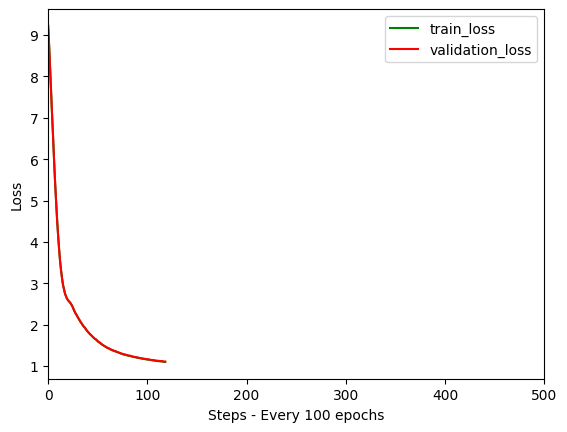

In [16]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]
plt.plot(train_loss_list_converted, 'g', label = 'train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.xlim(0, 500)
plt.show()
np.savetxt('train_loss.csv', train_loss_list_converted, delimiter=',')
np.savetxt('validation_loss.csv', validation_loss_list_converted, delimiter=',')

INFERENCE

In [5]:
#Load the model
nanoGPT = GPT.GPT(config)
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
nanoGPT.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states

number of parameters: 17.90M


C:\Users\priyankadutta\AppData\Local\Temp\ipykernel_28216\2246708991.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nanoGPT.load_state_dict(torch.load(best_model_params

<All keys matched successfully>

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Initialize tokenizer and model
try:
    indictrans_tokenizer = AutoTokenizer.from_pretrained(
        "ai4bharat/indictrans2-en-indic-dist-200M", trust_remote_code=True
    )
    indictrans_model = AutoModelForSeq2SeqLM.from_pretrained(
        "ai4bharat/indictrans2-en-indic-dist-200M", trust_remote_code=True
    )

    print(f"Tokenizer vocab size: {indictrans_tokenizer.vocab_size}")

    # Ensure that your config is set up for your NanoGPT
    print(f"Model vocab size: {config.vocab_size}")

    # Input sentence
    sentence = "एक बार की बात है "

    # Tokenize input sentence
    tokens = indictrans_tokenizer.encode(sentence, return_tensors="pt").to(device)

    print(f"\nTokens: {tokens}")
    print(f"Input token shape: {tokens.shape}")

    # Clip tokens if they exceed NanoGPT's vocabulary size
    if tokens.max() >= config.vocab_size:
        print("\nWarning: Some tokens exceed the vocabulary size of the model!")
        tokens = tokens.clamp(max=config.vocab_size - 1)

    # Prepare the context input
    context = tokens.to(device)
    print(f"\nContext shape: {context.shape}")

    # Set NanoGPT to evaluation mode
    nanoGPT.eval()

    # Generate text
    with torch.no_grad():
        with ctx:
            try:
                y = nanoGPT.generate(
                    context,
                    max_new_tokens=200,
                    temperature=0.8,  # Control randomness for coherent output
                    top_k=50  # Restrict sampling for meaningful output
                )

                # Convert output tokens to text
                generated_tokens = y[0].cpu().tolist()
                generated_text = indictrans_tokenizer.decode(generated_tokens, skip_special_tokens=True)

                # Clean up generated text
                generated_text = (
                    generated_text.replace("<pad>", "")
                    .replace("<unk>", "")
                    .replace("<s>", "")
                    .replace("</s>", "")
                    .strip()
                )

                print("\nGenerated text:")
                print(generated_text)

            except IndexError as e:
                print(f"\nIndex error during generation: {e}")

                # Handle long context issue by truncating
                if context.size(1) > config.block_size:
                    print("\nContext is too long; truncating to fit model block size...")
                    context = context[:, -config.block_size:]
                    y = nanoGPT.generate(
                        context,
                        max_new_tokens=50,  # Reduce the generation length for safety
                        temperature=0.8,
                        top_k=50
                    )
                    generated_tokens = y[0].cpu().tolist()
                    generated_text = indictrans_tokenizer.decode(generated_tokens, skip_special_tokens=True)

                    print("\nGenerated text with truncated context:")
                    print(generated_text)

except Exception as e:
    print(f"\nError: {str(e)}")
    import traceback
    traceback.print_exc()


Tokenizer vocab size: 200000
Model vocab size: 65400

Tokens: [2, 45, 9017, 1883, 78701, 4384, 45, 60957, 2525, 17636, 15, 3]
Max token value: 78701
Min token value: 2


Input shape: torch.Size([1, 12])

Generated text:
[CLS] एक बर क വ്യാപാരി ह एक कदद थ।[SEP]!<pad> उस<pad>क<pad> म<pad> न<pad> এলো<unk> क<pad> उस<pad>क<pad> म<pad> न<pad> उस<pad>क<pad> मदद<pad> क<pad> ह<pad>।<pad> उस<pad>क<pad> म<pad> मस<pad>कर<pad>ई<pad> और<pad> बल<pad>,<pad> "<pad>ન્ટ્સ[CLS]त<pad> भ<pad>,<pad> म<pad>,<pad> म<pad> हम<pad>श<pad> तम<pad>हर<pad> ल<pad>ए<pad> एक<pad> क<pad>क<pad> द<pad>ग<pad>!"<pad> उस<pad>न<pad> कह<pad>,<pad> "<pad>यह<pad> बह<pad>त<pad> गरम<pad> ह<pad>!<pad> चल<pad> इस<pad>क<pad> स<pad>थ<pad> क<pad>क<pad>य<pad> बन<pad> क<pad>छ<pad> क<pad>ग<pad>ज<pad> स<pad> बन<pad>हर<pad> क<pad> बन<pad>छ<pad>न<pad> क<pad> एक<pad> एक<pad> स<pad> सक<pad>क<pad>ज<pad> क<pad> ल<pad>त<pad> एक<pad>त<pad> <pad> सक<pad>स<pad>त<pad>त<pad> ह<pad>ज<pad> बन<pad>ट<pad> थ<pad>


Inference code to remove the "padding" and "special characters"